# Figure 5- Performance Over Session


In [18]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, friedmanchisquare, wilcoxon
from typing import Callable, Union, Sequence, Tuple, Optional

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Load


In [19]:
pdf = u.load_poke_df()
pdf["was_violation"] = pdf["was_valid"] == 0
g_pdf = pdf.query("stage in @c.GROWING_STAGES").copy()
pr_pdf = pdf.query("stage in @c.PROBE_STAGES").copy()

Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


## 1. Functions


## 1.1 Segmented Analysis


In [20]:
"""Segmented Analysis"""
GROUP_COLS: Tuple[str, ...] = (
    "sessid",
    "animal_id",
    "date",
    "fix_experiment",
)
# ------------------------------------------------------------------
# 1.  Partition trials into "first" / "last" buckets
# ------------------------------------------------------------------

def segment_trials(df: pd.DataFrame, n_trials: int, min_trials: int) -> pd.DataFrame:
    """Tag the *first* and *last* ``n_trials`` in a session.

    Parameters
    ----------
    df : pd.DataFrame
        Trial‑level dataframe for **one** session.
    n_trials : int
        How many trials to take from each end of the session.
    min_trials : int
        What is the minimum number of trials in a session to be included

    Returns
    -------
    pd.DataFrame
        Same rows, with a new ``segment`` column ("first" / "last")
        and only those rows kept.
    """
    if n_trials <= 0:
        raise ValueError("n_trials must be positive")

    df = df.sort_index().copy()
    total = len(df)

    if min_trials > total:
        print(f"Skipping sesssion with {total} trials; because less than minium {min_trials}")
        return pd.DataFrame()
    elif 2 * n_trials > total:
        print(f"Skipping session with {total} trials; cannot take {n_trials} from each end.")
        return pd.DataFrame()
    
    idx = np.arange(total)
    conds = [idx < n_trials, idx >= total - n_trials]
    df["segment"] = np.select(conds, ["first", "last"], default=pd.NA)

    return df.dropna(subset=["segment"])


# ------------------------------------------------------------------
# 2.  Generic “compute one metric per segment per session”
# ------------------------------------------------------------------

def compute_session_metric(
    df: pd.DataFrame,
    n_trials: int,
    min_trials: int,
    metric_col: str,
    out_col: str,
    *,
    filter_query: Optional[str] = None,
    agg_fn: Union[str, Callable] = "mean",
) -> pd.DataFrame:
    """Aggregate ``metric_col`` for the *first/last* ``n_trials`` in every session.

    All heavy lifting (filtering, segmentation, aggregation, re‑attaching
    session keys) happens here; wrapper helpers only specify which column
    to average and what to call the output.
    """

    if filter_query:
        df = df.query(filter_query).copy()

    results: Sequence[pd.DataFrame] = []

    for keys, g in df.groupby(list(GROUP_COLS)):
        seg = segment_trials(g, n_trials, min_trials)
        if seg.empty:
            continue
        agg = (
            seg.groupby("segment", observed=False)[metric_col]
            .agg(agg_fn)
            .reset_index()
            .rename(columns={metric_col: out_col})
        )
        # How many trials went into each estimate?
        agg["num_trials"] = seg.groupby("segment", observed=False).size().values

        # Unpack group‑by keys back onto rows
        for col, val in zip(GROUP_COLS, keys):
            agg[col] = val

        results.append(agg)

    return pd.concat(results, ignore_index=True)


# ------------------------------------------------------------------
# 3.  Wrappers
# ------------------------------------------------------------------

def compute_violation_rates_over_session(
    df: pd.DataFrame, n_trials: int, min_trials :int
) -> pd.DataFrame:
    """Average ``was_violation`` in the first/last blocks of a session."""

    return compute_session_metric(
        df,
        n_trials,
        min_trials,
        metric_col="was_violation",
        out_col="violation_rate",
    )


def compute_initiation_times_over_session(
    df: pd.DataFrame, n_trials: int, min_trials : int, stage_type: str
) -> pd.DataFrame:
    """Average initiation time (stage‑specific column) in the first/last blocks."""

    col_map = {
        "probe": "cpoke_iti_adjusted_summed",
        "growth": "cpoke_iti_adjusted",
    }
    if stage_type not in col_map:
        raise ValueError(f"Unknown stage_type '{stage_type}'")

    return compute_session_metric(
        df,
        n_trials,
        min_trials,
        metric_col=col_map[stage_type],
        out_col="initiation_time",
        # filter_query="was_valid == False",
    )


## 1.2 Plotting


In [21]:
def plot_over_session(
    df: pd.DataFrame,
    y_col: str,
    n_trials: int,
    x_col: str = "segment",
    hue: str = "fix_experiment",
    palette=None,
    hue_order=None,
    **ax_kwargs
) -> tuple[plt.Figure, plt.Axes]:
    """
    Create a seaborn pointplot of y_col over session segments.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing your data.
    y_col : str
        Name of the column to plot on the y–axis.
    n_trials : int
        Number of trials in each segment (used for xtick labels).
    x_col : str, default "segment"
        Name of the column encoding session segments (0, 1, …).
    hue : str, default "fix_experiment"
        Column to use for color/hue grouping.
    palette : dict or seaborn palette spec, optional
    hue_order : list, optional
    **ax_kwargs
        Any additional keyword arguments passed to `ax.set()`
        (e.g. xlabel, ylabel, ylim).

    Returns
    -------
    fig, ax : matplotlib objects
        The figure and axes containing the plot.
    """
    fig, ax = plt.subplots(figsize=(5, 6))
    sns.despine(ax=ax)
    sns.pointplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=hue,
        palette=palette,
        hue_order=hue_order,
        errorbar="se",
        ax=ax
    )

    # apply any extra axis settings
    ax.set(**ax_kwargs)

    # custom xticks assuming segments are 0 and 1
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f"First {n_trials} Trials", f"Last {n_trials} Trials"])

    # legend styling
    leg = ax.legend(title=None, frameon=False)

    plt.tight_layout()

    return fig, ax


def compute_df_stats(
    df: pd.DataFrame,
    y_col: str,
    groupby_cols: list[str] = ["fix_experiment", "segment"]
) -> pd.DataFrame:
    """
    Compute median, mean, std, and count for a given y-column
    grouped by the specified columns, and print the result.

    Parameters
    ----------
    df : pd.DataFrame
    y_col : str
        Column on which to compute statistics.
    groupby_cols : list of str
        Columns to group by before aggregation.

    Returns
    -------
    stats_df : pd.DataFrame
        The aggregated statistics.
    """
    stats_df = (
        df
        .groupby(groupby_cols)[y_col]
        .agg(median="median", mean="mean", std="std", count="size")
        .reset_index()
    )
    print(stats_df.to_string(index=False))
    return stats_df

## 1.3 Statistical Analysis


In [22]:
def compare_session_stats(
    df: pd.DataFrame,
    metric_col: str,
    between_cohort_tests: bool = False,
    alpha: float = 0.05,
    condition_col: str = "fix_experiment",
    segment_col: str = "segment",
    id_col: str = "sessid",
    first_label: str = "first",
    last_label: str = "last"
) -> pd.DataFrame:
    """
    Run Wilcoxon signed‐rank tests across segments (within‐subject) for each condition,
    and Mann‐Whitney U tests between conditions for each segment, with Holm correction.

    Parameters
    ----------
    df
        DataFrame containing your data.
    metric_col
        Name of the column with the measure you’re testing (e.g. "violation_rate_pct").
    between_cohort_tests
        Whether to run between‐cohort tests via Mann‐Whitney U tests.
    alpha
        Significance threshold (default 0.05).
    condition_col
        Column naming your between‐subject factor (e.g. "fix_experiment").
    segment_col
        Column naming your within‐subject factor (e.g. "segment").
    id_col
        Column with subject/session IDs for pairing.
    first_label, last_label
        The two levels of segment_col in the order you want to compare.

    Returns
    -------
    results : pd.DataFrame
        A tidy DataFrame with columns:
          - test_type: "within" or "between"
          - group: condition (for within) or segment (for between)
          - comparison: e.g. "first vs last" or "V1 vs V2"
          - test: "wilcoxon" or "mannwhitneyu"
          - statistic, p_value, p_adj, significant (bool)
    """
    results = []

    # WITHIN‐SUBJECT (Wilcoxon signed‐rank)
    for cond, sub in df.groupby(condition_col):
        wide = sub.pivot(index=id_col, columns=segment_col, values=metric_col).dropna()
        if {first_label, last_label}.issubset(wide.columns):
            stat, p = wilcoxon(wide[first_label], wide[last_label])
            results.append({
                "test_type": "within",
                "group": cond,
                "comparison": f"{first_label} vs {last_label}",
                "test": "wilcoxon",
                "statistic": stat,
                "p_value": p
            })

    # BETWEEN‐SUBJECT (Mann‐Whitney U)
    if between_cohort_tests:
        conds = df[condition_col].unique()
        if len(conds) != 2:
            raise ValueError("Between‐subject comparison requires exactly two conditions.")
        for seg in [first_label, last_label]:
            a = df[(df[condition_col] == conds[0]) & (df[segment_col] == seg)][metric_col]
            b = df[(df[condition_col] == conds[1]) & (df[segment_col] == seg)][metric_col]
            if len(a) and len(b):
                stat, p = mannwhitneyu(a, b, alternative="two-sided")
                results.append({
                    "test_type": "between",
                    "group": seg,
                    "comparison": f"{conds[0]} vs {conds[1]}",
                    "test": "mannwhitneyu",
                    "statistic": stat,
                    "p_value": p
                })

    # Apply Holm correction
    p_values = [result['p_value'] for result in results]
    n_tests = len(p_values)
    sorted_indices = sorted(range(len(p_values)), key=lambda i: p_values[i])
    sorted_p_values = sorted(p_values)
    adjusted_p_values = [min(p * (n_tests - i), 1.0) for i, p in enumerate(sorted_p_values)]
    for i, index in enumerate(sorted_indices):
        results[index]['p_adj'] = adjusted_p_values[i]
        results[index]['significant'] = adjusted_p_values[i] < alpha
        if adjusted_p_values[i] < 0.001:
            results[index]['marker'] = "***"
        elif adjusted_p_values[i] < 0.01:
            results[index]['marker'] = "**"
        elif adjusted_p_values[i] < 0.05:
            results[index]['marker'] = "*"
        else:
            results[index]['marker'] = "ns"

    return pd.DataFrame(results)


## 1.4 Parameters


In [23]:
N_TRIALS = 50 # segment size
MIN_TRIALS = 200 # minimum trials in a session
ALPHA = 0.05 # significance threshold


# Growing Stages


## Violation Rates


In [24]:
g_viol_over_session = compute_violation_rates_over_session(g_pdf, n_trials=N_TRIALS, min_trials = MIN_TRIALS)
g_viol_over_session["violation_rate_pct"] = g_viol_over_session["violation_rate"] * 100


Skipping sesssion with 91 trials; because less than minium 200
Skipping sesssion with 111 trials; because less than minium 200
Skipping sesssion with 51 trials; because less than minium 200
Skipping sesssion with 183 trials; because less than minium 200
Skipping sesssion with 11 trials; because less than minium 200
Skipping sesssion with 5 trials; because less than minium 200
Skipping sesssion with 1 trials; because less than minium 200
Skipping sesssion with 5 trials; because less than minium 200
Skipping sesssion with 24 trials; because less than minium 200
Skipping sesssion with 4 trials; because less than minium 200
Skipping sesssion with 2 trials; because less than minium 200
Skipping sesssion with 17 trials; because less than minium 200
Skipping sesssion with 7 trials; because less than minium 200
Skipping sesssion with 142 trials; because less than minium 200
Skipping sesssion with 17 trials; because less than minium 200
Skipping sesssion with 21 trials; because less than minium

fix_experiment segment  median      mean       std  count
            V1   first    20.0 22.546296 11.716722    216
            V1    last    24.0 25.601852 14.593047    216
            V2   first    68.0 66.098039 14.176755    102
            V2    last    34.0 35.568627 13.668284    102


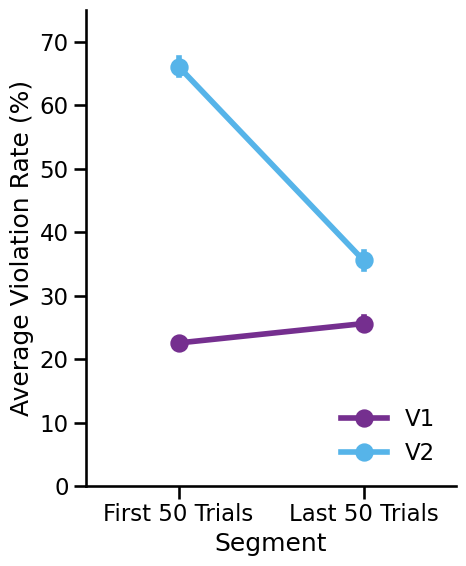

In [25]:
# your original data
df = g_viol_over_session

# 1. Plot
fig, ax = plot_over_session(
    df,
    y_col="violation_rate_pct",
    n_trials=N_TRIALS,
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    xlabel="Segment",
    ylabel="Average Violation Rate (%)",
    ylim=(0, 75),
)

ax.legend(loc="lower right", frameon=False)

# 2. Stats
stats = compute_df_stats(df, y_col="violation_rate_pct")

c.save_fig(fig, "fig5_growth_viol_rates_over_session")

In [26]:
compare_session_stats(g_viol_over_session, "violation_rate_pct")

,test_type,group,comparison,test,statistic,p_value,p_adj,significant,marker
0,within,V1,first vs last,wilcoxon,7803.0,3.224722e-03,3.224722e-03,True,**
1,within,V2,first vs last,wilcoxon,8.0,3.336665e-18,6.673330e-18,True,***


## Initiation Times


In [27]:
g_init_over_session = compute_initiation_times_over_session(g_pdf, n_trials=N_TRIALS, min_trials = MIN_TRIALS, stage_type="growth")

Skipping sesssion with 91 trials; because less than minium 200
Skipping sesssion with 111 trials; because less than minium 200
Skipping sesssion with 51 trials; because less than minium 200
Skipping sesssion with 183 trials; because less than minium 200
Skipping sesssion with 11 trials; because less than minium 200
Skipping sesssion with 5 trials; because less than minium 200
Skipping sesssion with 1 trials; because less than minium 200
Skipping sesssion with 5 trials; because less than minium 200
Skipping sesssion with 24 trials; because less than minium 200
Skipping sesssion with 4 trials; because less than minium 200
Skipping sesssion with 2 trials; because less than minium 200
Skipping sesssion with 17 trials; because less than minium 200
Skipping sesssion with 7 trials; because less than minium 200
Skipping sesssion with 142 trials; because less than minium 200
Skipping sesssion with 17 trials; because less than minium 200
Skipping sesssion with 21 trials; because less than minium

fix_experiment segment    median      mean       std  count
            V1   first 10.492513 11.352358  4.084663    216
            V1    last 20.263981 23.164398 12.198129    216
            V2   first 10.919910 14.588660 13.755705    102
            V2    last 14.237856 15.196178  7.388539    102


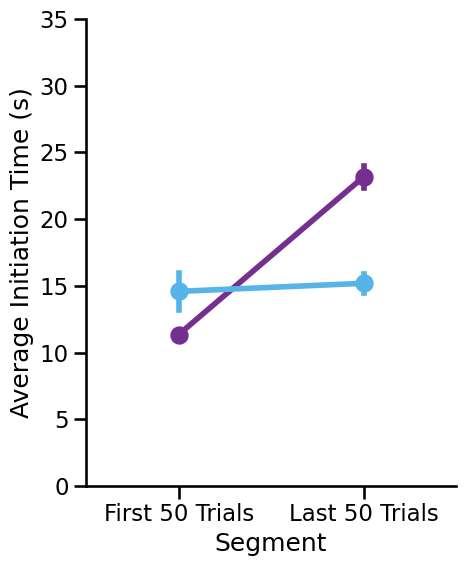

In [29]:
# your original data
df = g_init_over_session

# 1. Plot
fig, ax = plot_over_session(
    df,
    y_col="initiation_time",
    n_trials=N_TRIALS,
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    xlabel="Segment",
    ylabel="Average Initiation Time (s)",
    ylim=(0, 35),
)
ax.legend().remove()

# 2. Stats
stats = compute_df_stats(df, y_col="initiation_time")

c.save_fig(fig, "fig5_growth_init_times_over_session")

In [16]:
compare_session_stats(g_init_over_session, "initiation_time")

,test_type,group,comparison,test,statistic,p_value,p_adj,significant,marker
0,within,V1,first vs last,wilcoxon,9.0,0.016113,0.032227,True,*
1,within,V2,first vs last,wilcoxon,494.0,0.113167,0.113167,False,ns


# Probe Stages

## Violation Rates


In [78]:
pr_viol_over_session = compute_violation_rates_over_session(pr_pdf, n_trials=N_TRIALS, min_trials = MIN_TRIALS)
pr_viol_over_session["violation_rate_pct"] = pr_viol_over_session["violation_rate"] * 100


Skipping sesssion with 196 trials; because less than minium 200
Skipping sesssion with 149 trials; because less than minium 200
Skipping sesssion with 197 trials; because less than minium 200
Skipping sesssion with 161 trials; because less than minium 200
Skipping sesssion with 146 trials; because less than minium 200
Skipping sesssion with 194 trials; because less than minium 200
Skipping sesssion with 165 trials; because less than minium 200
Skipping sesssion with 70 trials; because less than minium 200
Skipping sesssion with 101 trials; because less than minium 200
Skipping sesssion with 182 trials; because less than minium 200
Skipping sesssion with 150 trials; because less than minium 200
Skipping sesssion with 189 trials; because less than minium 200
Skipping sesssion with 195 trials; because less than minium 200
Skipping sesssion with 166 trials; because less than minium 200


fix_experiment segment  median      mean       std  count
            V1   first    24.0 25.164179 12.702418     67
            V1    last    10.0 12.626866  7.840910     67
            V2   first    16.0 18.197183  9.526834     71
            V2    last    12.0 12.845070  8.735229     71


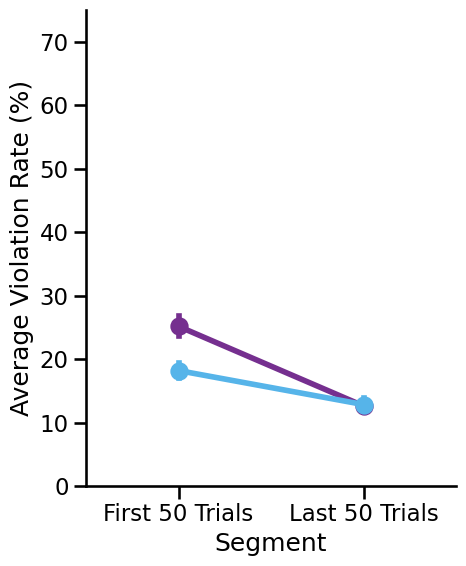

In [80]:
# your original data
df = pr_viol_over_session

# 1. Plot
fig, ax = plot_over_session(
    df,
    y_col="violation_rate_pct",
    n_trials=N_TRIALS,
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    xlabel="Segment",
    ylabel="Average Violation Rate (%)",
    ylim=(0, 75),
)

ax.legend().remove()
# 2. Stats
stats = compute_df_stats(df, y_col="violation_rate_pct")

c.save_fig(fig, "fig5_probe_viol_rates_over_session")

In [81]:
compare_session_stats(pr_viol_over_session, "violation_rate_pct")

,test_type,group,comparison,test,statistic,p_value,p_adj,significant,marker
0,within,V1,first vs last,wilcoxon,104.5,2.454961e-10,4.909921e-10,True,***
1,within,V2,first vs last,wilcoxon,508.0,2.820480e-05,2.820480e-05,True,***


## Initiation Times


In [82]:
pr_init_over_session = compute_initiation_times_over_session(pr_pdf, n_trials=N_TRIALS, min_trials = MIN_TRIALS, stage_type="probe")

Skipping sesssion with 196 trials; because less than minium 200
Skipping sesssion with 149 trials; because less than minium 200
Skipping sesssion with 197 trials; because less than minium 200
Skipping sesssion with 161 trials; because less than minium 200
Skipping sesssion with 146 trials; because less than minium 200
Skipping sesssion with 194 trials; because less than minium 200
Skipping sesssion with 165 trials; because less than minium 200
Skipping sesssion with 70 trials; because less than minium 200
Skipping sesssion with 101 trials; because less than minium 200
Skipping sesssion with 182 trials; because less than minium 200
Skipping sesssion with 150 trials; because less than minium 200
Skipping sesssion with 189 trials; because less than minium 200
Skipping sesssion with 195 trials; because less than minium 200
Skipping sesssion with 166 trials; because less than minium 200


fix_experiment segment    median      mean       std  count
            V1   first 14.083252 15.454105  8.793538     67
            V1    last 23.191829 26.492391 12.481793     67
            V2   first 11.650753 13.527156  6.416959     71
            V2    last 19.464179 21.129489  8.419422     71


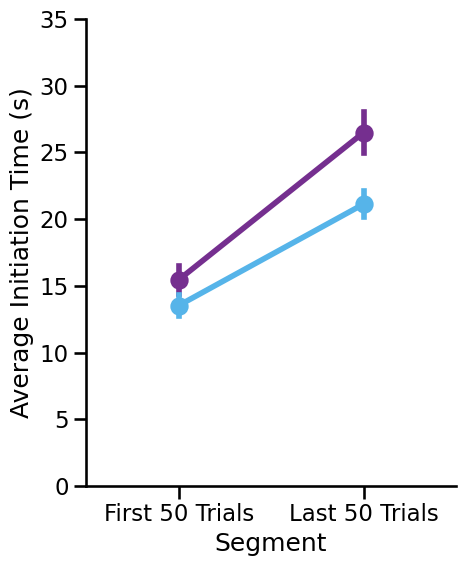

In [83]:
# your original data
df = pr_init_over_session

# 1. Plot
fig, ax = plot_over_session(
    df,
    y_col="initiation_time",
    n_trials=N_TRIALS,
    palette=c.EXP_PALETTE,
    hue_order=c.HUE_ORDER_EXP,
    xlabel="Segment",
    ylabel="Average Initiation Time (s)",
    ylim=(0, 35),
)
ax.legend().remove()

# 2. Stats
stats = compute_df_stats(df, y_col="initiation_time")

c.save_fig(fig, "fig5_probe_init_times_over_session")

In [85]:
compare_session_stats(pr_init_over_session, "initiation_time")

,test_type,group,comparison,test,statistic,p_value,p_adj,significant,marker
0,within,V1,first vs last,wilcoxon,190.0,3.065217e-09,6.130435e-09,True,***
1,within,V2,first vs last,wilcoxon,338.0,7.202466e-08,7.202466e-08,True,***
